# Using a combination of 2 3D datasets (Fermi-LAT and HESS), 2 1D dataset (MAGIC, CTA-LST1) and 1 Flux Points Dataset (HAWC)
## This includes datasets with global and energy-dependent directional cuts,
## using DL3/5 files produced using GADF-compliant and other formats

In [1]:
import logging
import os

import astropy.units as u
import matplotlib.pyplot as plt
from gammapy.datasets import FluxPointsDataset
from gammapy.estimators import FluxPoints
from gammapy.modeling.models import Models, create_crab_spectral_model

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig
from asgardpy.data.target import apply_selection_mask_to_models, set_models

In [2]:
# os.environ['GAMMAPY_DATA']

In [3]:
log = logging.getLogger("test DL4 steps")

In [4]:
config_file = "../src/asgardpy/tests/config_crab_mult_instruments.yaml"

In [5]:
config = AsgardpyConfig()

In [6]:
%%time
config_main = config.read(config_file)

CPU times: user 17.3 ms, sys: 2.28 ms, total: 19.6 ms
Wall time: 19.2 ms


# Update path of test data

In [7]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[1].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"
config_main.dataset3d.instruments[
    1
].dataset_info.background.exclusion.exclusion_file = (
    f"{os.environ['GAMMAPY_DATA']}joint-crab/exclusion/exclusion_mask_crab.fits.gz/"
)
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}magic/rad_max/data/"
config_main.dataset1d.instruments[
    1
].dl4_dataset_info.dl4_dataset.input_dir = f"{os.environ['GAMMAPY_DATA']}cta-lst1/"

In [8]:
config_main.general.dict()

{'log': {'level': 'info',
  'filename': '',
  'filemode': 'w',
  'format': '',
  'datefmt': ''},
 'outdir': PosixPath('.'),
 'n_jobs': 50,
 'parallel_backend': 'multiprocessing',
 'steps': ['datasets-3d', 'datasets-1d', 'fit', 'flux-points'],
 'overwrite': True,
 'stacked_dataset': True}

# Steps mentioned in the main config file

In [9]:
config_main.general.steps

['datasets-3d', 'datasets-1d', 'fit', 'flux-points']

In [10]:
config_main.target.dict()

{'source_name': '4FGL J0534.5+2201i',
 'sky_position': {'frame': 'icrs',
  'lon': <Quantity 83.63308333 deg>,
  'lat': <Quantity 22.0145 deg>,
  'radius': <Quantity 0. deg>},
 'use_uniform_position': True,
 'models_file': PosixPath('.'),
 'datasets_with_fov_bkg_model': [],
 'use_catalog': {'name': '',
  'selection_radius': <Quantity 0. deg>,
  'exclusion_radius': <Quantity 0. deg>},
 'components': [{'name': '4FGL J0534.5+2201i',
   'type': 'SkyModel',
   'datasets_names': [''],
   'spectral': {'type': 'LogParabolaSpectralModel',
    'parameters': [{'name': 'amplitude',
      'value': 1e-06,
      'unit': 'cm-2 s-1 TeV-1',
      'error': 1.5e-07,
      'min': 1e-13,
      'max': 0.01,
      'frozen': False},
     {'name': 'reference',
      'value': 0.015,
      'unit': 'TeV',
      'error': 0.0,
      'min': 0.0001,
      'max': 100.0,
      'frozen': True},
     {'name': 'alpha',
      'value': 1.7,
      'unit': '',
      'error': 0.1,
      'min': 0.5,
      'max': 5.0,
      'froze

# Datasets informations

In [11]:
config_main.dataset3d.dict()

{'type': '3d',
 'instruments': [{'name': 'Fermi-LAT',
   'input_dl3': [{'type': 'lat',
     'input_dir': PosixPath('/home/chaitanya/software/gammapy-datasets/1.2/fermipy-crab'),
     'glob_pattern': {'events': 'ft1*.fits*',
      'edisp': 'drm*.fits*',
      'xml_model': 'srcmdl*.xml',
      'exposure': 'bexpmap*.fits*',
      'psf': 'psf*.fits*'}},
    {'type': 'lat-aux',
     'input_dir': PosixPath('/home/chaitanya/software/gammapy-datasets/1.2/fermipy-crab'),
     'glob_pattern': {'gal_diffuse': 'gll_iem_v07_cutout.fits*',
      'iso_diffuse': 'iso_P8R3_SOURCE_V3_*.txt'}}],
   'input_dl4': False,
   'dataset_info': {'name': 'Fermi-LAT',
    'key': ['00', '01'],
    'observation': {'obs_ids': [],
     'obs_file': PosixPath('.'),
     'obs_time': [],
     'obs_cone': {'frame': 'icrs',
      'lon': <Quantity 0. deg>,
      'lat': <Quantity 0. deg>,
      'radius': <Quantity 0. deg>},
     'required_irfs': ['aeff']},
    'map_selection': ['counts', 'exposure', 'background', 'psf', 'edis

In [12]:
config_main.dataset1d.dict()

{'type': '1d',
 'instruments': [{'name': 'MAGIC',
   'input_dl3': [{'type': 'gadf-dl3',
     'input_dir': PosixPath('/home/chaitanya/software/gammapy-datasets/1.2/magic/rad_max/data'),
     'glob_pattern': {'dl3': '2013*fits'}}],
   'input_dl4': False,
   'dataset_info': {'name': 'MAGIC',
    'geom': {'wcs': {'skydir': {'frame': 'icrs',
       'lon': <Quantity 0. deg>,
       'lat': <Quantity 0. deg>,
       'radius': <Quantity 0. deg>},
      'binsize': <Quantity 0.02 deg>,
      'proj': 'TAN',
      'map_frame_shape': {'width': <Quantity 6. deg>,
       'height': <Quantity 6. deg>},
      'binsize_irf': <Quantity 0.2 deg>},
     'selection': {'offset_max': <Quantity 2.5 deg>},
     'axes': [{'name': 'energy',
       'axis': {'min': <Quantity 0.05 TeV>,
        'max': <Quantity 10. TeV>,
        'nbins': 5,
        'per_decade': True},
       'axis_custom': {'edges': [], 'unit': 'TeV'}},
      {'name': 'energy_true',
       'axis': {'min': <Quantity 0.01 TeV>,
        'max': <Quantity

# DL4 step information

In [13]:
config_main.fit_params.dict()

{'fit_range': {'min': <Quantity 1. GeV>, 'max': <Quantity 300. TeV>},
 'backend': 'minuit',
 'optimize_opts': {},
 'covariance_opts': {},
 'confidence_opts': {},
 'store_trace': True}

In [14]:
config_main.flux_points_params.dict()

{'parameters': {'selection_optional': 'all'}, 'reoptimize': False}

In [15]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


CPU times: user 1.16 ms, sys: 185 µs, total: 1.35 ms
Wall time: 964 µs


In [16]:
analysis

# Prepare the dataset

In [17]:
instruments_list_3d = config_main.dataset3d.instruments
print(len(instruments_list_3d), "number of 3D dataset information provided")

config_3d_dataset = instruments_list_3d[0]
print(f"Instrument selected is {config_3d_dataset.name}")

2 number of 3D dataset information provided
Instrument selected is Fermi-LAT


In [18]:
instruments_list_1d = config_main.dataset1d.instruments
print(len(instruments_list_1d), "number of 1D dataset information provided")

2 number of 1D dataset information provided


In [19]:
key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

The list of different keys or modes of observations for the selected instrument are ['00', '01']


# Run each Dataset nD Generation step

In [20]:
%%time
analysis.run(["datasets-3d"])

Perform DL3 to DL4 process!
2 number of 3D Datasets given
The different keys used: 00 01
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.
Using the exclusion mask to create a safe mask
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astr

CPU times: user 5.06 s, sys: 150 ms, total: 5.21 s
Wall time: 5.66 s


## Display some results

In [21]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_00
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0540.3+2756e', 'fermi-diffuse-iso-00', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_01
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0540.3+2756e', 'diffuse-iem', 'fermi-diffuse-iso-01']

Dataset 2: 

  Type       : MapDataset
  Name       : R22urjBA
  Instrument : HESS
  Models     : ['4FGL J0534.5+2201i']




In [22]:
print(analysis.final_model)

Models

Component 0: SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'R22urjBA']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi   

In [23]:
for m in analysis.final_model:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'R22urjBA']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (froz

In [24]:
print(analysis.instrument_spectral_info)

{'name': ['Fermi-LAT', 'HESS'], 'spectral_energy_ranges': [<Quantity [  1.        ,   2.87298483,   8.25404185,  23.71373706,
            68.12920691, 195.73417815, 562.34132519] GeV>, <Quantity [ 1.        ,  1.58489319,  2.51188643,  3.98107171,  6.30957344,
           10.        ] TeV>], 'en_bins': 58, 'free_params': 7, 'DoF': 51}


In [25]:
print(analysis.dataset_name_list)

['Fermi-LAT_00', 'Fermi-LAT_01', 'R22urjBA']


In [26]:
%%time
analysis.run(["datasets-1d"])

Perform DL3 to DL4 process!
2 number of 1D Datasets given
Observation ID list selected: 5029747 5029748
Observations selected: 2 out of 2.
Using 2 processes to compute Data reduction
Computing dataset for observation 5029747
Computing dataset for observation 5029748
Running SpectrumDatasetMaker
Running SpectrumDatasetMaker
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D 

CPU times: user 203 ms, sys: 24.9 ms, total: 228 ms
Wall time: 449 ms


## Display the results

In [27]:
analysis.datasets[2]._name = "HESS"
analysis.dataset_name_list[2] = "HESS"

In [28]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_00
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0540.3+2756e', 'fermi-diffuse-iso-00', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_01
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0540.3+2756e', 'diffuse-iem', 'fermi-diffuse-iso-01']

Dataset 2: 

  Type       : MapDataset
  Name       : HESS
  Instrument : HESS
  Models     : ['4FGL J0534.5+2201i']

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : MAGIC
  Instrument : 
  Models     : ['4FGL J0534.5+2201i']

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : LST-1
  Instrument : 
  Models     : ['4FGL J0534.5+22

In [29]:
for d in analysis.datasets:
    print(d)

/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 23266 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 29105.95
  Predicted background counts     : nan
  Predicted excess counts         : 29105.95

  Exposure min                    : 5.80e+10 cm2 s
  Exposure max                    : 7.19e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 186744 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24456.27

  Number of models                : 10 
  Number of parameters            : 59
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialMod

/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_01 

  Total counts                    : 22981 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 28500.83
  Predicted background counts     : nan
  Predicted excess counts         : 28500.83

  Exposure min                    : 4.52e+10 cm2 s
  Exposure max                    : 6.50e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 186744 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 48680.94

  Number of models                : 10 
  Number of parameters            : 59
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialMod

In [30]:
for m in analysis.final_model:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi          

In [31]:
print(analysis.instrument_spectral_info)

{'name': ['Fermi-LAT', 'HESS', 'MAGIC', 'LST-1'], 'spectral_energy_ranges': [<Quantity [  1.        ,   2.87298483,   8.25404185,  23.71373706,
            68.12920691, 195.73417815, 562.34132519] GeV>, <Quantity [ 1.        ,  1.58489319,  2.51188643,  3.98107171,  6.30957344,
           10.        ] TeV>, <Quantity [0.0631, 0.1   , 0.1585, 0.2512, 0.3981, 0.631 , 1.    , 1.585 ,
           2.512 ] TeV>, <Quantity [2.510e-02, 3.980e-02, 6.310e-02, 1.000e-01, 1.585e-01,
           2.512e-01, 3.981e-01, 6.310e-01, 1.000e+00, 1.585e+00,
           2.512e+00, 3.981e+00, 6.310e+00, 1.000e+01, 1.585e+01,
           2.512e+01] TeV>], 'en_bins': 90, 'free_params': 16, 'DoF': 74}


In [32]:
for i, en_range in enumerate(analysis.instrument_spectral_info["spectral_energy_ranges"]):
    print(
        f"The spectral energy range to be used for dataset {analysis.instrument_spectral_info['name'][i]} is {en_range}"
    )

The spectral energy range to be used for dataset Fermi-LAT is [  1.           2.87298483   8.25404185  23.71373706  68.12920691
 195.73417815 562.34132519] GeV
The spectral energy range to be used for dataset HESS is [ 1.          1.58489319  2.51188643  3.98107171  6.30957344 10.        ] TeV
The spectral energy range to be used for dataset MAGIC is [0.0631 0.1    0.1585 0.2512 0.3981 0.631  1.     1.585  2.512 ] TeV
The spectral energy range to be used for dataset LST-1 is [2.510e-02 3.980e-02 6.310e-02 1.000e-01 1.585e-01 2.512e-01 3.981e-01
 6.310e-01 1.000e+00 1.585e+00 2.512e+00 3.981e+00 6.310e+00 1.000e+01
 1.585e+01 2.512e+01] TeV


In [33]:
print(analysis.dataset_name_list)

['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1']


## HAWC Flux Points data has to be added to the DL4 datasets, before running Fit
### This is to be done without adding any spectral_energy_range as FluxPointsEstimator will not be run on this HAWC dataset.

In [34]:
filename = f"{os.environ['GAMMAPY_DATA']}hawc_crab/HAWC19_flux_points.fits"
fp_hawc = FluxPoints.read(filename, reference_model=create_crab_spectral_model("meyer"))
fpd_hawc = FluxPointsDataset(data=fp_hawc, name="HAWC")

Inferred format: gadf-sed


In [35]:
analysis.datasets.append(fpd_hawc)
analysis.dataset_name_list.append("HAWC")

In [36]:
for d in analysis.datasets:
    print(d.name)

Fermi-LAT_00
Fermi-LAT_01
HESS
MAGIC
LST-1
HAWC


# Preparing the Datasets for DL4 steps

In [37]:
analysis.final_model = Models(analysis.final_model)

In [38]:
# Only updating the target source model with names of all datasets
if len(analysis.final_model) > 1:
    analysis.final_model = apply_selection_mask_to_models(
        list_sources=analysis.final_model,
        target_source=analysis.config.target.source_name,
        roi_radius=analysis.config.target.roi_selection.roi_radius,
        free_sources=analysis.config.target.roi_selection.free_sources,
    )

In [39]:
for model_ in analysis.final_model:
    print(model_)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1', 'HAWC']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi  

## Assigning the models to all the datasets

In [40]:
analysis.datasets, analysis.final_model = set_models(
    analysis.config.target,
    analysis.datasets,
    analysis.dataset_name_list,
    models=analysis.final_model,
)

In [41]:
%%time
for d in analysis.datasets:
    print(d)

/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 23266 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 29105.95
  Predicted background counts     : nan
  Predicted excess counts         : 29105.95

  Exposure min                    : 5.80e+10 cm2 s
  Exposure max                    : 7.19e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 186744 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24456.27

  Number of models                : 10 
  Number of parameters            : 59
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1', 'HAWC']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSp

/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_01 

  Total counts                    : 22981 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 28500.83
  Predicted background counts     : nan
  Predicted excess counts         : 28500.83

  Exposure min                    : 4.52e+10 cm2 s
  Exposure max                    : 6.50e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 186744 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 48680.94

  Number of models                : 10 
  Number of parameters            : 59
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1', 'HAWC']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSp

In [42]:
len(list(analysis.final_model.parameters.free_parameters))

9

# Run the Fit step

In [43]:
%%time
analysis.run(["fit"])

Perform DL4 to DL5 processes!
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 795
	total stat : 75296.69

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Analysis Step fit completed
The Chi2/dof value of the goodness of Fit is 125.53/74
and the p-value is 1.738e-04 and in Significance 3.75 sigmas
with best fit TS (Observed) as -4382.093 and max fit TS (Expected) as -4507.626


CPU times: user 1min 39s, sys: 838 ms, total: 1min 39s
Wall time: 1min 39s


In [44]:
print(analysis.fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 795
	total stat : 75296.69

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [45]:
for m in analysis.datasets[0].models:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS', 'MAGIC', 'LST-1', 'HAWC']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   2.83e-07   +/- 1.1e-08 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.787   +/-    0.02             
    beta                          :      0.080   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi  

# Run the Flux Points Estimator step

In [46]:
%%time
analysis.run(["flux-points"])

Perform DL4 to DL5 processes!
Limiting number of processes from 50 to 20
Using 20 processes to compute Energy bins
/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya/mambaforge/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home

CPU times: user 2.69 s, sys: 3.81 s, total: 6.5 s
Wall time: 34.1 s


In [47]:
for fp in analysis.flux_points:
    print(fp)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 6)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'stat_null', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 5)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'stat_null', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood

FluxPoints
----------

  geom     

In [48]:
fermi_fpt = analysis.flux_points[0].to_table(sed_type="e2dnde", formatted=True)
fermi_fpt

Inferred format: gadf-sed


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float32[2],float64,float64,bool,float64[2],bool,float64[11],float64[11]
0.002,0.001,0.003,2.601e-11,1.734e-12,1.739e-12,1.729e-12,2.950e-11,246.548,15.702,18395.462920607308 .. 18153.361572015587,1011.08093 .. 996.8685,41093.948,41340.496,False,18690.0 .. 18376.0,True,0.200 .. 5.000,41242.291 .. 44317.721
0.005,0.003,0.007,4.848e-11,2.787e-12,2.804e-12,2.770e-12,5.412e-11,385.696,19.639,3464.3628460922164 .. 3413.005695866609,527.74774 .. 519.2181,15447.338,15833.034,False,3315.0 .. 3379.0,True,0.200 .. 5.000,15689.455 .. 17849.021
0.013,0.007,0.024,6.115e-11,3.129e-12,3.162e-12,3.096e-12,6.754e-11,725.480,26.935,1106.0014555471735 .. 1033.591773490654,340.61023 .. 317.61072,6882.565,7608.045,False,973.0 .. 967.0,True,0.200 .. 5.000,7261.512 .. 9444.957
0.042,0.024,0.075,6.986e-11,4.622e-12,4.718e-12,4.530e-12,7.951e-11,1073.664,32.767,234.4578546732841 .. 214.8288466561679,130.72153 .. 119.77631,2249.061,3322.725,False,215.0 .. 193.0,True,0.200 .. 5.000,2564.922 .. 3486.807
0.115,0.075,0.178,6.802e-11,8.413e-12,8.761e-12,8.075e-12,8.627e-11,679.630,26.070,52.36479564329983 .. 45.3224787100848,35.532265 .. 30.769344,714.125,1393.755,False,52.0 .. 45.0,True,0.200 .. 5.000,814.462 .. 1048.384
0.316,0.178,0.562,5.561e-11,1.072e-11,1.143e-11,1.005e-11,7.993e-11,336.079,18.332,21.2015278966213 .. 17.259864330830112,14.887625 .. 12.123572,266.602,602.681,False,15.0 .. 19.0,True,0.200 .. 5.000,308.191 .. 404.758


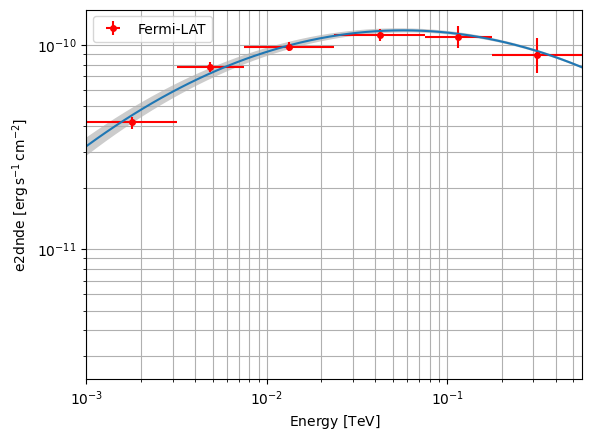

In [49]:
analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 10 * u.TeV]
)
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 10 * u.TeV]
)

plt.grid(which="both")
plt.legend()

In [50]:
hess_fpt = analysis.flux_points[1].to_table(sed_type="e2dnde", formatted=True)
hess_fpt

Inferred format: gadf-sed


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
1.259,1.000,1.585,3.944e-11,6.700e-12,7.017e-12,6.388e-12,5.412e-11,114.212,10.687,358.49141120756553,47.77182,3131.333,3245.544,False,317.0,True,0.200 .. 5.000,3181.264 .. 3279.488
1.995,1.585,2.512,3.738e-11,6.219e-12,6.527e-12,5.921e-12,5.108e-11,150.705,12.276,214.14091243038277,46.387413,2122.818,2273.523,False,204.0,True,0.200 .. 5.000,2187.058 .. 2225.603
3.162,2.512,3.981,1.979e-11,4.957e-12,5.313e-12,4.608e-12,3.114e-11,60.842,7.800,125.98548451844499,22.024124,1449.542,1510.383,False,125.0,True,0.200 .. 5.000,1470.590 .. 1540.643
5.012,3.981,6.310,2.066e-11,5.445e-12,5.889e-12,5.013e-12,3.335e-11,67.517,8.217,81.61212568558418,18.127558,1007.489,1075.006,False,83.0,True,0.200 .. 5.000,1034.566 .. 1047.743
7.943,6.310,10.000,1.420e-11,5.952e-12,6.686e-12,5.245e-12,2.908e-11,25.470,5.047,43.8604853857303,8.12814,777.611,803.081,False,58.0,True,0.200 .. 5.000,787.545 .. 795.126


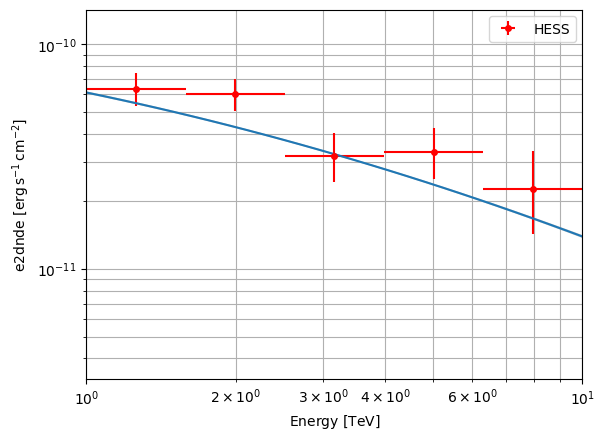

In [51]:
analysis.flux_points[1].plot(sed_type="e2dnde", color="red", label="HESS")
analysis.datasets[1].models[0].spectral_model.plot(sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV])
analysis.datasets[1].models[0].spectral_model.plot_error(sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV])

plt.grid(which="both")
plt.legend()

In [52]:
magic_fpt = analysis.flux_points[2].to_table(sed_type="e2dnde", formatted=True)
magic_fpt

Inferred format: gadf-sed


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.097,0.078,0.121,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.151,0.121,0.188,6.327e-11,6.241e-12,6.367e-12,6.115e-12,7.623e-11,160.003,12.649,201.08371789724785,149.7575,0.000,160.003,False,201.0,True,0.200 .. 5.000,90.204 .. 719.598
0.234,0.188,0.292,6.494e-11,6.066e-12,6.225e-12,5.911e-12,7.772e-11,224.371,14.979,146.98650326406704,131.98604,0.000,224.371,False,147.0,True,0.200 .. 5.000,131.012 .. 567.120
0.365,0.292,0.455,7.462e-11,6.907e-12,7.100e-12,6.720e-12,8.923e-11,249.313,15.790,135.9637527167168,127.29632,0.000,249.313,False,136.0,True,0.200 .. 5.000,165.639 .. 349.472
0.567,0.455,0.707,4.193e-11,5.721e-12,5.976e-12,5.472e-12,5.439e-11,133.273,11.544,56.00712568293761,55.007168,0.000,133.273,False,56.0,True,0.200 .. 5.000,66.879 .. 327.339
0.882,0.707,1.100,5.785e-11,7.858e-12,8.201e-12,7.525e-12,7.495e-11,128.758,11.347,57.9979526601043,56.331264,0.000,128.758,False,58.0,True,0.200 .. 5.000,88.220 .. 137.237
1.371,1.100,1.710,2.956e-11,6.416e-12,6.875e-12,5.972e-12,4.426e-11,53.345,7.304,22.001149531541394,21.667822,0.000,53.345,False,22.0,True,0.200 .. 5.000,27.602 .. 121.710
2.132,1.710,2.659,2.654e-11,7.093e-12,7.740e-12,6.477e-12,4.337e-11,38.816,6.230,13.996740838647904,13.996741,0.000,38.816,False,14.0,True,0.200 .. 5.000,22.521 .. 63.582


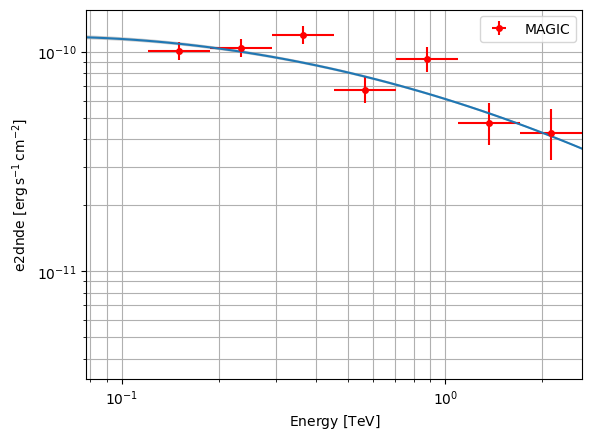

In [53]:
analysis.flux_points[2].plot(sed_type="e2dnde", color="red", label="MAGIC")
analysis.datasets[2].models[0].spectral_model.plot(sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV])
analysis.datasets[2].models[0].spectral_model.plot_error(sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV])

plt.grid(which="both")
plt.legend()

In [54]:
lst_fpt = analysis.flux_points[3].to_table(sed_type="e2dnde", formatted=True)
lst_fpt

Inferred format: gadf-sed


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.032,0.025,0.040,1.621e-11,2.763e-11,2.768e-11,nan,7.149e-11,0.339,0.583,90021.66190110316,248.32198,0.000,0.339,True,90021.0,True,0.200 .. 5.000,0.004 .. 151.415
0.050,0.040,0.063,1.116e-11,1.907e-11,1.913e-11,nan,4.928e-11,0.332,0.576,89076.59272626364,246.18105,0.000,0.332,True,89075.0,True,0.200 .. 5.000,0.036 .. 344.723
0.079,0.063,0.100,6.951e-11,1.605e-11,1.606e-11,1.606e-11,1.015e-10,18.674,4.321,49548.0924689581,1353.1552,0.000,18.674,False,49547.0,True,0.200 .. 5.000,11.667 .. 334.904
0.126,0.100,0.158,7.036e-11,1.008e-11,1.009e-11,1.008e-11,9.053e-11,48.685,6.977,15368.031726856776,1199.061,0.000,48.685,False,15368.0,True,0.200 .. 5.000,31.289 .. 750.199
0.200,0.158,0.251,7.126e-11,4.503e-12,4.509e-12,4.498e-12,8.029e-11,252.904,15.903,2698.0004580073464,1044.0007,0.000,252.904,False,2698.0,True,0.200 .. 5.000,169.808 .. 2358.778
0.316,0.251,0.398,6.506e-11,3.308e-12,3.322e-12,3.295e-12,7.173e-11,403.735,20.093,1212.0054361273988,794.0073,0.000,403.735,False,1212.0,True,0.200 .. 5.000,275.651 .. 2488.068
0.501,0.398,0.631,5.504e-11,2.923e-12,2.947e-12,2.900e-12,6.099e-11,387.650,19.689,658.9594098913244,528.9514,0.000,387.650,False,659.0,True,0.200 .. 5.000,265.289 .. 1946.398
0.794,0.631,1.000,4.501e-11,2.847e-12,2.884e-12,2.811e-12,5.086e-11,285.393,16.894,362.9976823038536,318.9974,0.000,285.393,False,363.0,True,0.200 .. 5.000,195.711 .. 1284.345


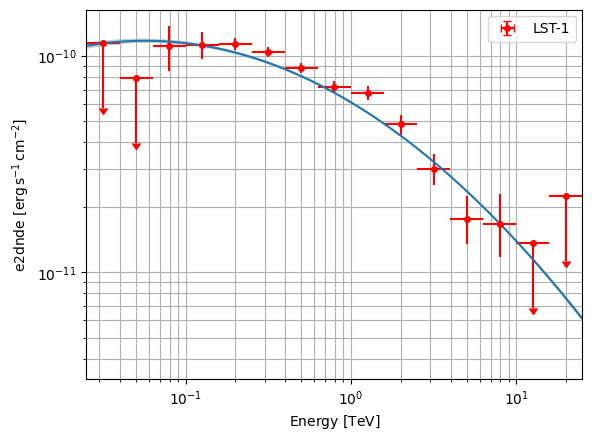

In [55]:
analysis.flux_points[3].plot(sed_type="e2dnde", color="red", label="LST-1")
analysis.datasets[3].models[0].spectral_model.plot(sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV])
analysis.datasets[3].models[0].spectral_model.plot_error(sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV])

plt.grid(which="both")
plt.legend()

In [56]:
hawc_fpt = fp_hawc.to_table(sed_type="e2dnde", formatted=True)
hawc_fpt

Inferred format: gadf-sed


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_ul,ts,sqrt_ts,is_ul
TeV,TeV,TeV,erg / (s cm2),erg / (s cm2),erg / (s cm2),,,
float64,float64,float64,float64,float64,float64,float64,float64,bool
1.334,1.000,1.780,5.201e-11,1.146e-12,nan,2734.000,52.288,False
2.372,1.780,3.160,3.774e-11,7.068e-13,nan,4112.000,64.125,False
4.214,3.160,5.620,2.582e-11,5.379e-13,nan,4678.000,68.396,False
7.497,5.620,10.000,1.793e-11,4.338e-13,nan,3683.000,60.688,False
13.342,10.000,17.800,1.117e-11,4.247e-13,nan,2259.000,47.529,False
23.717,17.800,31.600,6.518e-12,3.614e-13,nan,1237.000,35.171,False
42.142,31.600,56.200,4.064e-12,3.491e-13,nan,572.000,23.917,False
74.967,56.200,100.000,2.995e-12,5.844e-13,nan,105.000,10.247,False


# Final SED plot with all instruments

(0.0007, 500.0)

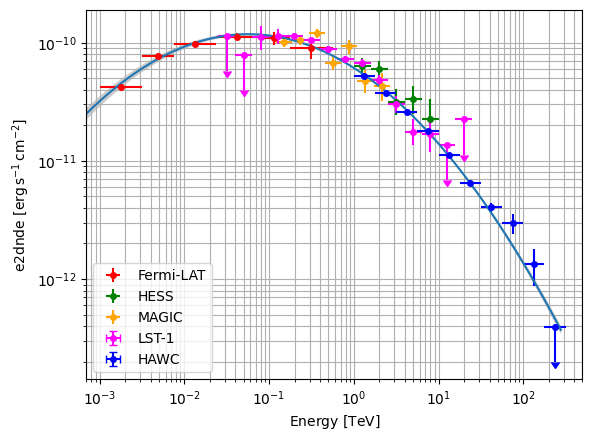

In [57]:
analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
analysis.flux_points[1].plot(sed_type="e2dnde", color="green", label="HESS")
analysis.flux_points[2].plot(sed_type="e2dnde", color="orange", label="MAGIC")
analysis.flux_points[3].plot(sed_type="e2dnde", color="magenta", label="LST-1")
fp_hawc.plot(sed_type="e2dnde", color="blue", label="HAWC")

analysis.datasets[1].models[0].spectral_model.plot(sed_type="e2dnde", energy_bounds=[70 * u.MeV, 300 * u.TeV])
analysis.datasets[1].models[0].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 300 * u.TeV]
)

plt.grid(which="both")
plt.legend()
plt.xlim(7e-4, 5e2)